<a href="https://colab.research.google.com/github/reibek/progn-semestral-work/blob/main/Progonstics_Semestral_work_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import warnings
import itertools
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Enviroment settings.

In [2]:
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

# Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/FRI/PROGN/SK_TAVG_Trend.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data insight

Data contains an extracted regional summary of land-surface temperature results produced by the Berkeley Earth averaging method for the region of **Slovakia**.

Temperatures are in Celsius and reported as anomalies relative to the January 1951 - December 1980 average. Uncertainties represent the 95% confidence interval for statistical noise and spatial undersampling effects.

This analysis was run on 06-Jan-2021 15:35:34

The current region is characterized by: 
*   Name: Slovakia
*   Latitude Range: 47.75 to 49.60
*   Longitude Range: 16.84 to 22.54
*   Area: 48377.12 km^2
*   Percent of global land area: 0.033 %
*   Approximate number of temperature stations: 46
*   Approximate number of monthly obeservations: 22170

Estimated January 1951 - December 1980 absolute temperature (°C): 7.52 +/- 0.45

Estimated Jan 1951-Dec 1980 monthly absolute temperature (C):

|     | Jan | Feb | Mar | Apr | May | Jun | Jul | Aug | Sep | Oct | Nov | Dec |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
|     | -3.70 | -1.77 | 2.20 | 7.45 | 12.39 | 16.02 | 17.40 | 16.93 | 13.27 | 8.21 | 3.18 | -1.36 |
| +/- | 0.58 | 0.50 | 0.48 | 0.53 | 0.53 | 0.50 | 0.49 | 0.48 | 0.45 | 0.47 | 0.50 | 0.56 |

In [4]:
monthly_abs_temperature = [-3.70, -1.77, 2.20, 7.45, 12.39, 16.02, 17.40, 16.93, 13.27, 8.21, 3.18, -1.36]

We will run a basic analysis of our dataset including preview, NaN values summary and dataset info.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252 entries, 0 to 3251
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  3252 non-null   int64  
 1   Month                 3252 non-null   int64  
 2   MonthlyAnomaly        3251 non-null   float64
 3   MonthlyAnomalyUnc     3251 non-null   float64
 4   AnnualAnomaly         3233 non-null   float64
 5   AnnuralAnomalyUnc     3233 non-null   float64
 6   FiveYearAnomaly       3160 non-null   float64
 7   FiveYearAnomalyUnc    3160 non-null   float64
 8   TenYearAnomaly        3100 non-null   float64
 9   TenYearAnomalyUnc     3100 non-null   float64
 10  TwentyYearAnomaly     2980 non-null   float64
 11  TwentyYearAnomalyUnc  2980 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 305.0 KB


In [6]:
df.describe()

,Year,Month,MonthlyAnomaly,MonthlyAnomalyUnc,AnnualAnomaly,AnnuralAnomalyUnc,FiveYearAnomaly,FiveYearAnomalyUnc,TenYearAnomaly,TenYearAnomalyUnc,TwentyYearAnomaly,TwentyYearAnomalyUnc
count,3252.00000,3252.000000,3251.000000,3251.000000,3233.000000,3233.000000,3160.000000,3160.000000,3100.000000,3100.000000,2980.000000,2980.000000
mean,1885.00000,6.500000,-0.156355,1.355326,-0.159859,0.580594,-0.169064,0.383882,-0.184185,0.332458,-0.203371,0.275071
std,78.24246,3.452583,1.940423,1.572614,0.831639,0.605212,0.542940,0.369598,0.460844,0.306877,0.383514,0.238611
min,1750.00000,1.000000,-10.527000,0.071000,-2.738000,0.033000,-1.300000,0.027000,-0.987000,0.029000,-0.755000,0.016000
25%,1817.00000,3.750000,-1.266000,0.302500,-0.711000,0.127000,-0.529000,0.078000,-0.502250,0.070000,-0.468000,0.070000
50%,1885.00000,6.500000,-0.054000,0.601000,-0.179000,0.299000,-0.261500,0.208000,-0.266000,0.182000,-0.285000,0.157500
75%,1953.00000,9.250000,1.111500,1.905500,0.350000,0.888000,0.055500,0.585500,-0.004750,0.512000,-0.038750,0.455000
max,2020.00000,12.000000,6.090000,10.899000,2.862000,4.281000,1.894000,1.584000,1.676000,1.290000,1.314000,1.019000


In [7]:
df.head()

,Year,Month,MonthlyAnomaly,MonthlyAnomalyUnc,AnnualAnomaly,AnnuralAnomalyUnc,FiveYearAnomaly,FiveYearAnomalyUnc,TenYearAnomaly,TenYearAnomalyUnc,TwentyYearAnomaly,TwentyYearAnomalyUnc
0,1750,1,-0.306,1.732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1750,2,0.277,2.294,-0.245,0.940,NaN,NaN,NaN,NaN,NaN,NaN
2,1750,3,2.140,2.689,-0.237,0.950,NaN,NaN,NaN,NaN,NaN,NaN
3,1750,4,0.413,1.539,-0.233,0.939,NaN,NaN,NaN,NaN,NaN,NaN
4,1750,5,-1.227,1.544,-0.496,0.932,NaN,NaN,NaN,NaN,NaN,NaN


First, we will make dataset index to be datetime type from columns `Month` and `Year`.

In [8]:
cols = ['Year', 'Month']
df['Date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
df['Date']=pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.asfreq('MS') # Month Start

Since we will focus on monthly data, we can drop other columns.

In [9]:
df.drop(['Month', 'Year', 'MonthlyAnomalyUnc', 'AnnualAnomaly', 'AnnuralAnomalyUnc', 'FiveYearAnomaly', 'FiveYearAnomalyUnc', 'TenYearAnomaly', 'TenYearAnomalyUnc', 'TwentyYearAnomaly', 'TwentyYearAnomalyUnc'], 
        axis='columns', inplace=True)

In [10]:
df.isnull().sum()

MonthlyAnomaly    1
dtype: int64

Now, we will look at NaN values. We can see, that there's only one NaN value in our data. It will be replaced using mehod `bfill`, what means, that we replace value by it's previous value.

In [11]:
df.fillna(method='bfill', inplace=True)

Next, we will prepare also data with absolute monthly temperatures, not only anomalities.

In [12]:
df['MonthlyAverage'] = 0.0

for i in range(0, df.MonthlyAnomaly.size):
    df.MonthlyAverage[i] = df.MonthlyAnomaly[i] + monthly_abs_temperature[i % 12]

Let's plot our data.

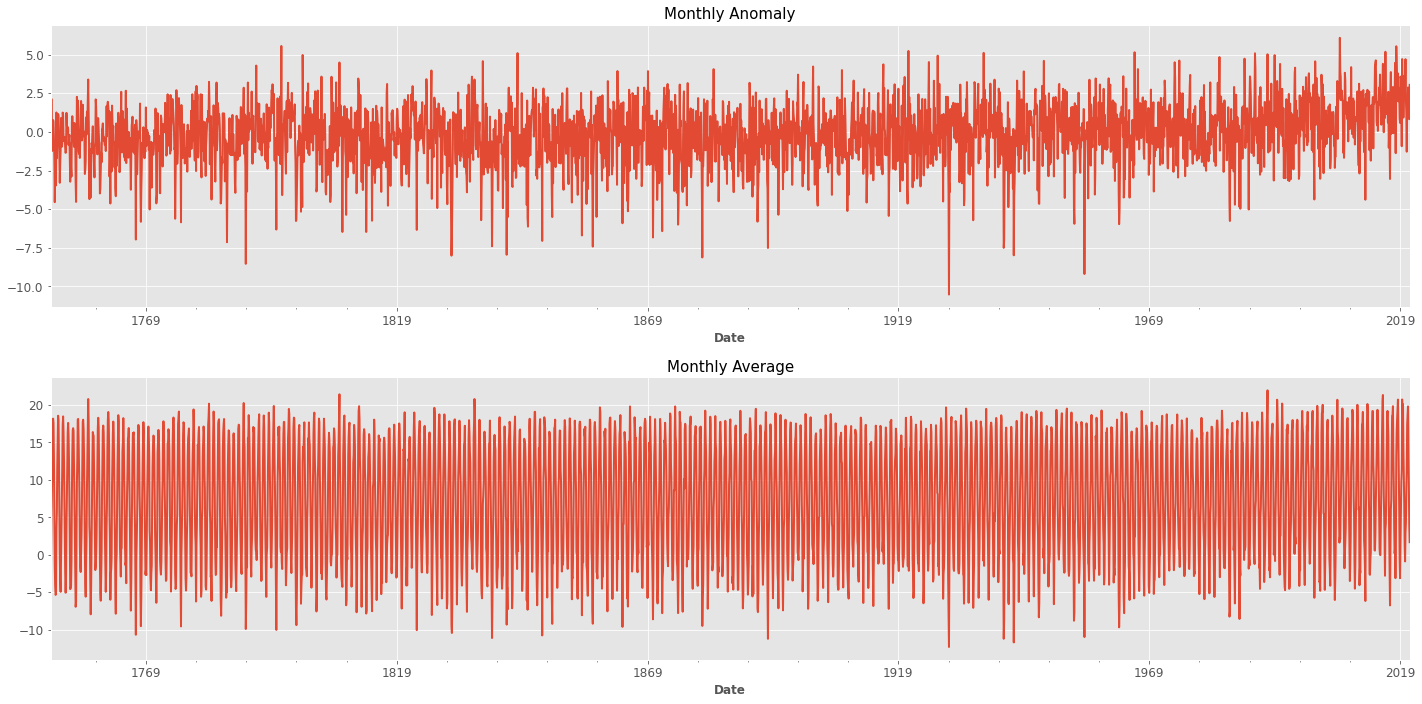

In [13]:
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.title('Monthly Anomaly',fontsize=15)
df.MonthlyAnomaly.plot()

plt.subplot(2,1,2)
plt.title('Monthly Average',fontsize=15)
df.MonthlyAverage.plot()

plt.tight_layout()

We can also closely inspect different decades.

In [14]:
def get_timeseries(timeseries, year_from, year_to):
    return timeseries[datetime.datetime(year_from, 1, 1):datetime.datetime(year_to, 12, 31)]

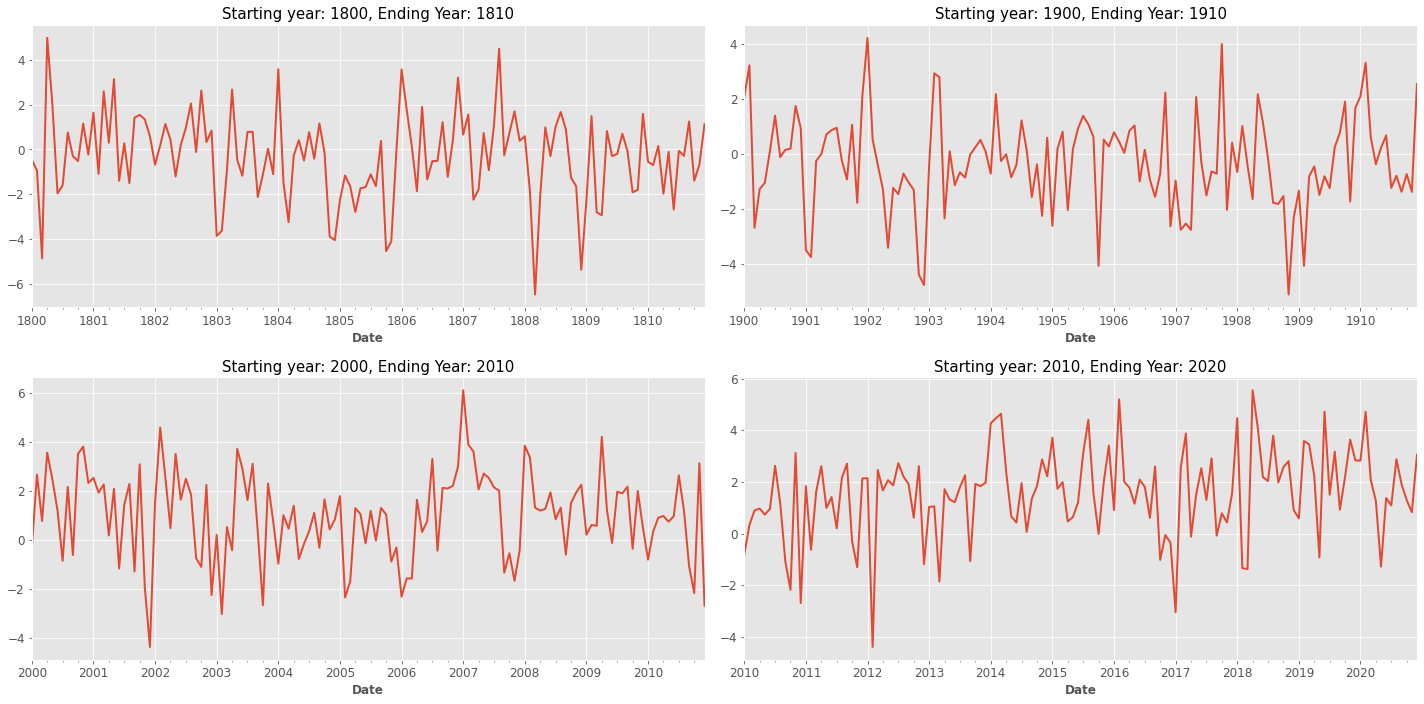

In [15]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.title('Starting year: 1800, Ending Year: 1810',fontsize=15)
get_timeseries(df.MonthlyAnomaly, 1800, 1810).plot()
plt.subplot(2,2,2)
plt.title('Starting year: 1900, Ending Year: 1910',fontsize=15)
get_timeseries(df.MonthlyAnomaly, 1900, 1910).plot()
plt.subplot(2,2,3)
plt.title('Starting year: 2000, Ending Year: 2010',fontsize=15)
get_timeseries(df.MonthlyAnomaly, 2000, 2010).plot()
plt.subplot(2,2,4)
plt.title('Starting year: 2010, Ending Year: 2020',fontsize=15)
get_timeseries(df.MonthlyAnomaly, 2010, 2020).plot()
plt.tight_layout()

We are interested in predicting future progress of temperature anomalities, so now we will focus on last decade from 2010 to 2020.

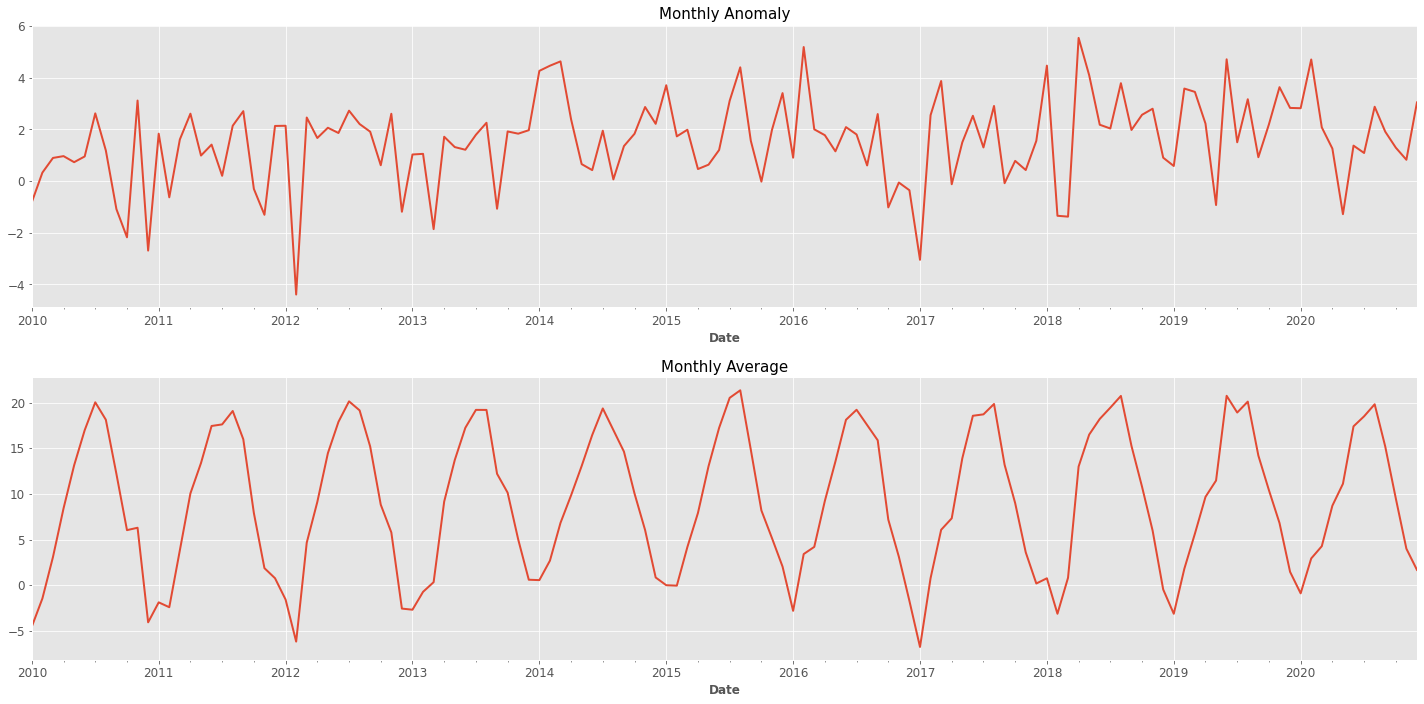

In [16]:
df_2010 = get_timeseries(df, 2010, 2020)

plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.title('Monthly Anomaly',fontsize=15)
df_2010.MonthlyAnomaly.plot()

plt.subplot(2,1,2)
plt.title('Monthly Average',fontsize=15)
df_2010.MonthlyAverage.plot()

plt.tight_layout()

# Analysis

## Seasonal decompose

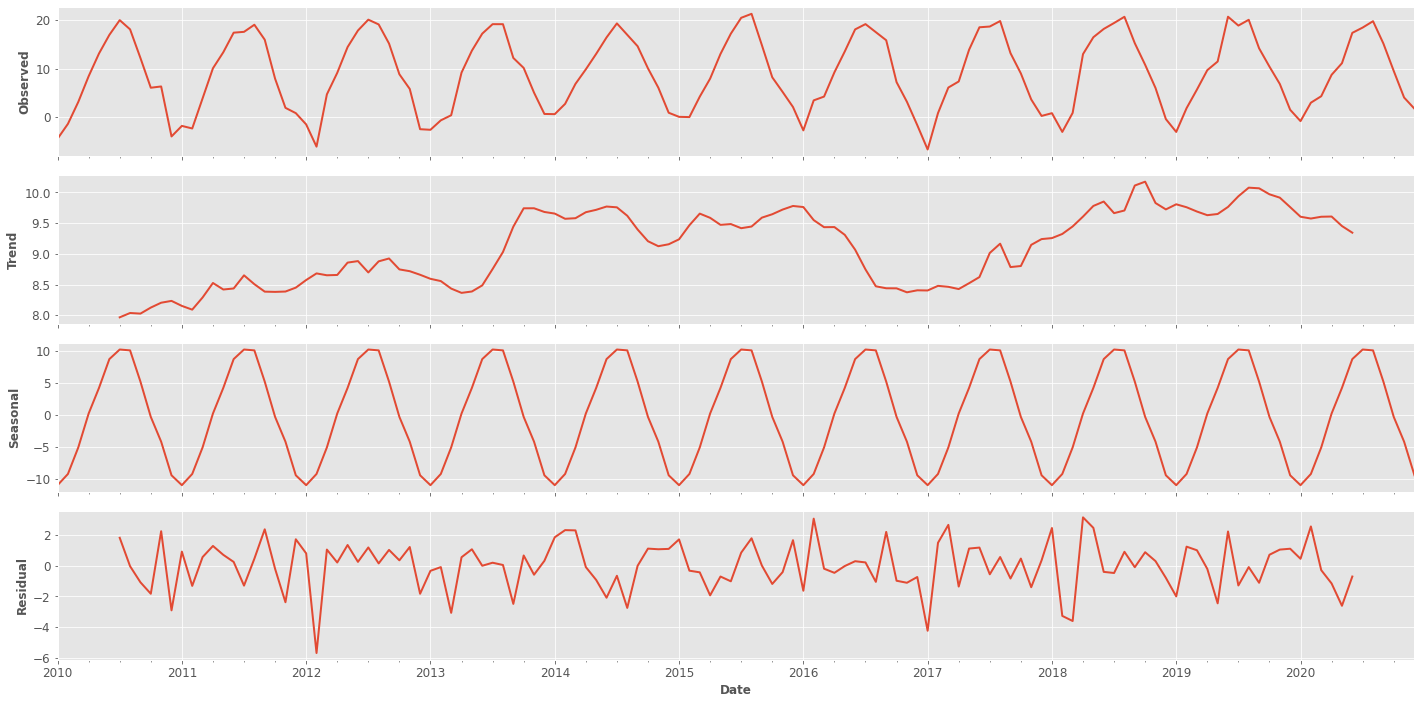

In [36]:
plt.rcParams['figure.figsize'] = [20, 10]
seasonal_decompose(df_2010.MonthlyAverage).plot();

## Stationarity

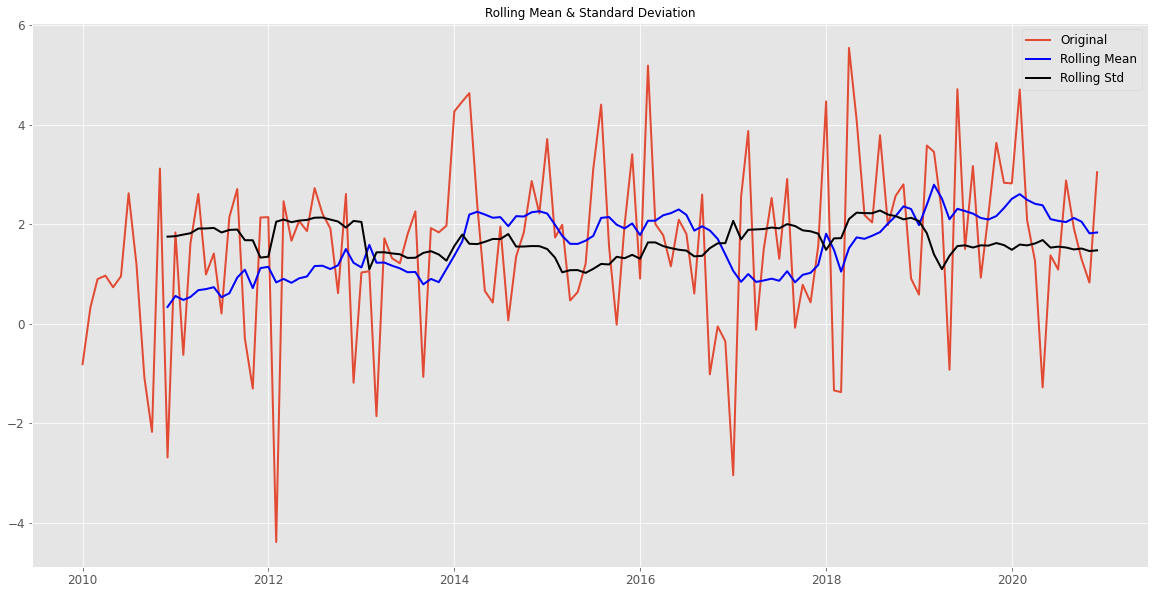

ADF Statistic: -10.550841390728406
p-value: 8.184072829252524e-19
Critical Values:
	1%: 	-3.481281802271349
	5%: 	-2.883867891664528
	10%: 	-2.5786771965503177


In [18]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, label='Original')
    mean = plt.plot(rolling_mean, color='blue', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: \t{}'.format(key, value))

plt.rcParams['figure.figsize'] = [20, 10]
get_stationarity(df_2010.MonthlyAnomaly)

In [19]:
def corr_plot(y, lags=30, figsize=(20, 5)):

    fig = plt.figure(figsize=figsize)
    layout = (1, 2)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (0, 1))

    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
    return

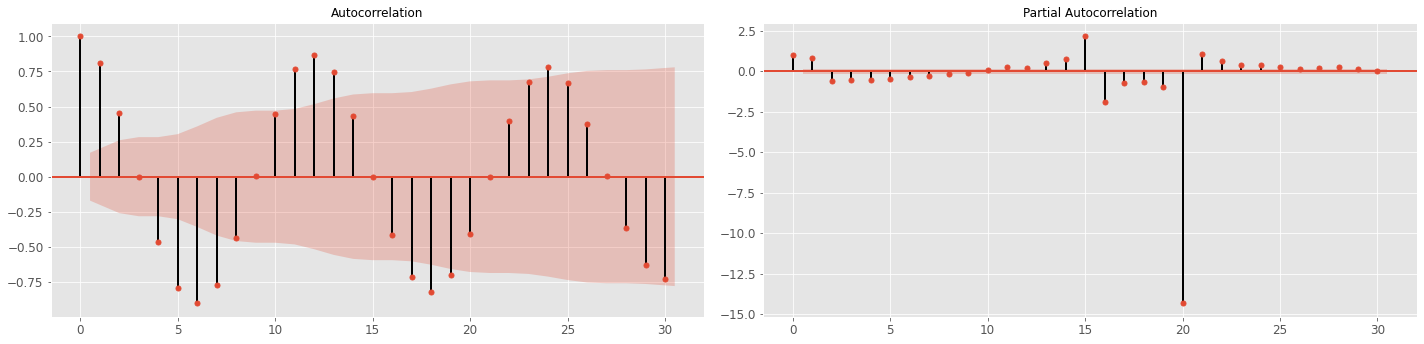

In [30]:
corr_plot(df_2010.MonthlyAverage)

In [23]:
p = q = range(0, 3)
d = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [31]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_2010.MonthlyAverage,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1022.6725691944863
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:819.9229341980661
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:687.0080022822401
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:554.2927005936216
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:442.92961998775263
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:398.63538719575286
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:560.032870709719
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:499.4604669302588
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:452.52255605058025
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:470.9605397869665
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:448.4001802412906
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:398.70464524850354
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:472.8645960926032
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:453.4062824926726
ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:446.8707196132128
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:412.00072357332704
ARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:409.12185972912084
ARIMA(0, 0, 0)x(2, 1, 2, 12)12 - AIC:404.000199131163
ARIMA

In [33]:
mod = sm.tsa.statespace.SARIMAX(df_2010.MonthlyAverage,order=(0,0,2),seasonal_order=(0,1,2,12),enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()

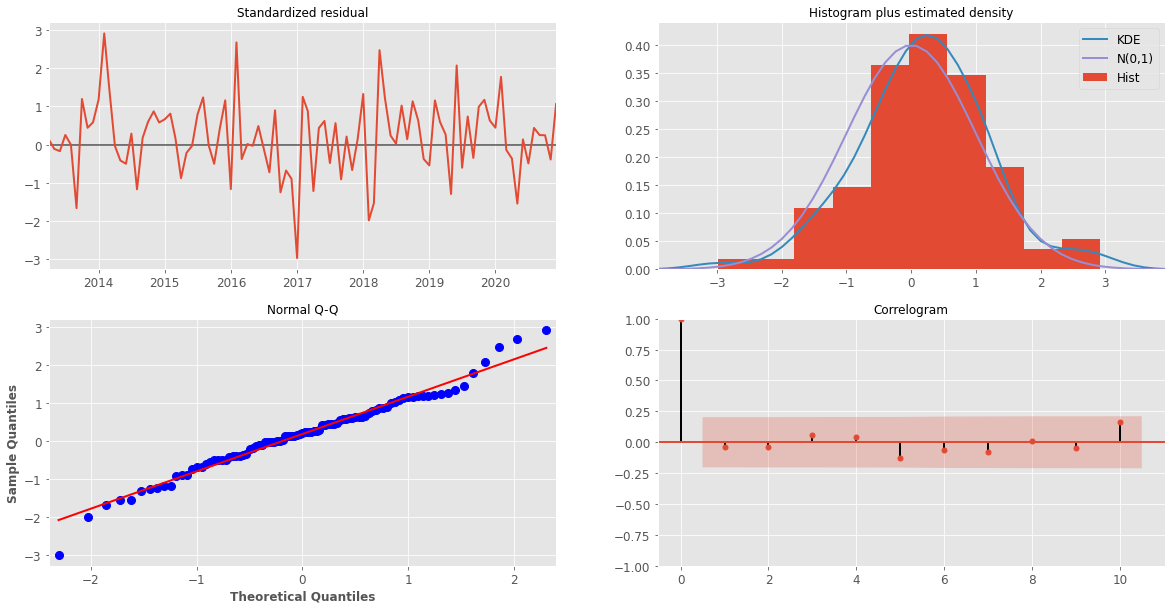

In [27]:
results.plot_diagnostics()
plt.show()

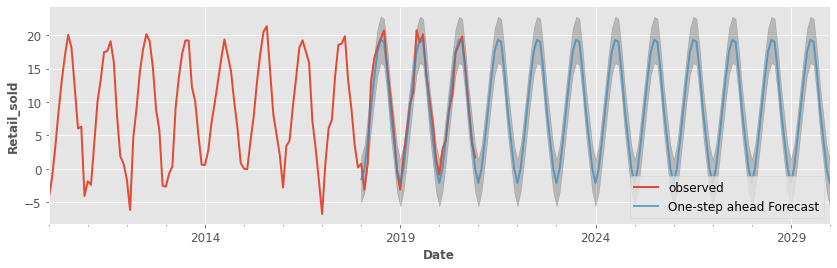

In [41]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-01'), end=pd.to_datetime('2030-01-01'), dynamic=True)
pred_ci = pred.conf_int()
ax = df_2010.MonthlyAverage['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()